# Recipe Recommender

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_recipes = pd.read_csv('./data/RAW_recipes.csv')
raw_interactions = pd.read_csv('./data/RAW_interactions.csv')

In [3]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['tags', 'steps', 'ingredients']
for feature in features:
    raw_recipes[feature] = raw_recipes[feature].apply(literal_eval)

In [4]:
raw_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [5]:
raw_interactions.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

In [6]:
raw_interactions.iloc[0]

user_id                                                  38094
recipe_id                                                40893
date                                                2003-02-17
rating                                                       4
review       Great with a salad. Cooked on top of stove for...
Name: 0, dtype: object

In [7]:
raw_recipes[raw_recipes.id == 62] #20080

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
24367,black bean corn and tomato salad,62,25,1570,1999-08-19,"[30-minutes-or-less, time-to-make, course, mai...","[407.8, 23.0, 17.0, 0.0, 34.0, 11.0, 18.0]",4,"[in a bowl whisk together lemon juice , oil , ...","this is easy, delicious, colorful, delicious, ...","[fresh lemon juice, olive oil, black beans, fr...",9


In [8]:
raw_interactions[raw_interactions.recipe_id == 6389]

,user_id,recipe_id,date,rating,review


In [9]:
raw_recipes[raw_recipes.reid == 62]

AttributeError: 'DataFrame' object has no attribute 'reid'

In [ ]:
raw_recipes.dtypes

In [ ]:
raw_recipes.head()

In [12]:
raw_recipes.shape

(231637, 12)

In [1]:
raw_interactions.head()

NameError: name 'raw_interactions' is not defined

In [14]:
raw_interactions.shape

(1132367, 5)

Creating a TF-IDF Vectorizer

Calculating Cosine Similarity

Making a recommendation

In [15]:
#raw_interactions[raw_nteractions]
# raw_interactions[["recipe_id", "rating"]].groupby("recipe_id").agg({"rating": ['mean', "count"]})
recipe_ratings_cnt = raw_interactions[["recipe_id", "rating"]].groupby("recipe_id").count().sort_values('rating', ascending=False).reset_index()
recipe_ratings_cnt.columns = ["id", "rating_count"]


In [16]:
recipe_ratings_cnt.shape

(231637, 2)

In [17]:
# get recipes with more than 20 ratings
filter = recipe_ratings_cnt['rating_count'] > 20
recipe_ratings_cnt = recipe_ratings_cnt[filter]

In [18]:
recipe_ratings_cnt.shape

(7478, 2)

In [19]:
# Get recipes that have ratings of 4 or more
recipe_ratings_mean = raw_interactions[raw_interactions["recipe_id"].isin(recipe_ratings_cnt["id"])] \
                [["recipe_id", "rating"]].groupby("recipe_id").mean().sort_values('rating', ascending=False).reset_index()
recipe_ratings_mean.columns = ["id", "rating_mean"]

In [20]:
recipe_ratings_mean.shape

(7478, 2)

In [21]:
recipe_ratings_mean.head()

,id,rating_mean
0,20080,5.0
1,278655,5.0
2,378378,5.0
3,29619,5.0
4,146558,5.0


In [22]:
# get recipes with more than 20 ratings
filter = recipe_ratings_mean['rating_mean'] >= 4
recipe_ratings_mean = recipe_ratings_mean[filter]

/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating_mean', ylabel='Density'>

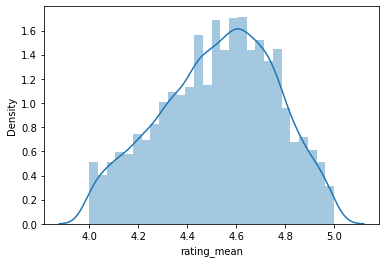

In [23]:

sns.distplot(recipe_ratings_mean['rating_mean'])

In [24]:
recipe_ratings_mean['rating_mean'].describe()

count    6699.000000
mean        4.525680
std         0.235046
min         4.000000
25%         4.357143
50%         4.543974
75%         4.701941
max         5.000000
Name: rating_mean, dtype: float64

In [25]:
recipe_ratings_mean.head()

,id,rating_mean
0,20080,5.0
1,278655,5.0
2,378378,5.0
3,29619,5.0
4,146558,5.0


In [26]:
# subset of recipes based on filters
recipes = raw_recipes[raw_recipes["id"].isin(recipe_ratings_mean["id"])]

In [27]:
# subset of interactions based on filters
interactions = raw_interactions[raw_interactions["recipe_id"].isin(recipe_ratings_mean["id"])]

In [28]:
recipes = recipes.reset_index(drop=True)

In [29]:
# Recipes data set
recipes['ingredients'][0]

['egg roll wrap', 'whole green chilies', 'cheese', 'cornstarch', 'oil']

In [30]:
interactions = interactions.reset_index(drop=True)

In [31]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,1110776,78274,2014-05-15,5,Love it!
1,1668373,207860,2010-09-26,5,"very easy to make, and much tastier than store..."
2,28649,33096,2002-07-29,5,This was very simple and very refreshing. Thi...
3,30298,33096,2002-07-30,4,Light and refreshing! I used a reduced fat gr...
4,87300,33096,2003-06-22,5,"This is such a perfect summer dessert, and SO ..."


In [32]:
# Interactions data set
interactions.shape

(382260, 5)

In [33]:
# group reviews by
interactions_group_review = []
for (recipe_id, group) in interactions[["recipe_id", "review"]].groupby("recipe_id"):
    #reviews_tmp = []
    reviews_tmp = [review for review in group['review']]
    #for review in group["review"]:
    #    reviews_tmp.append(review)
    interactions_group_review.append([recipe_id, reviews_tmp])

In [34]:
len(interactions_group_review)

6699

In [35]:
new_interactions = pd.DataFrame(interactions_group_review, columns=["id", "review"])

In [36]:
new_interactions.shape

(6699, 2)

In [42]:
recipes.shape

(6699, 12)

In [43]:
recipes = pd.merge(recipes, new_interactions, how="left", on="id")

In [44]:
recipes.shape

(6699, 13)

In [45]:
recipes.loc[recipes["id"]==62]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review
784,black bean corn and tomato salad,62,25,1570,1999-08-19,"[30-minutes-or-less, time-to-make, course, mai...","[407.8, 23.0, 17.0, 0.0, 34.0, 11.0, 18.0]",4,"[in a bowl whisk together lemon juice , oil , ...","this is easy, delicious, colorful, delicious, ...","[fresh lemon juice, olive oil, black beans, fr...",9,[This recipe was awesome! I took it to a famil...


#### Recommender system

In [100]:
recommend_recipes = recipes.copy()

In [101]:
recommend_recipes.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review
0,chile rellenos,43026,45,52268,2002-10-14,"[60-minutes-or-less, time-to-make, course, mai...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"[drain green chiles, sprinkle cornstarch on sh...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5,"[Grandma Pam,\r\n Oh my goodness,these were s..."
1,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, mai...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"[preheat oven to 350 degrees, place spinach in...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",8,[The recipe was good but too salty. I agree w...
2,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"[60-minutes-or-less, time-to-make, course, mai...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"[brown the meat & drain fat, stir in sugar , m...",just the thing for a day when you're wanton so...,"[ground beef, sugar, prepared yellow mustard, ...",8,[These are so good!! My family devoured them -...
3,land of nod cinnamon buns,22526,35,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, pre...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"[before you turn in for the night , grease a 1...",i have made this several times and it's dead e...,"[rolls, brown sugar, instant vanilla pudding, ...",6,[I made these a while back for a fellowship me...
4,never weep whipped cream,74805,5,87877,2003-11-01,"[15-minutes-or-less, time-to-make, course, mai...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,[whip all ingredients together until firm peak...,"i don't know where i got this, but it works. t...","[whipping cream, vanilla instant pudding mix, ...",4,"[I don't know why this works, but it sure does..."


##### Clean data and feature engineering

In [48]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x)
        else:
            return ''
        
# create a column with all words needed for the recommender 
def create_soup(x):
    return ' '.join(x['ingredients']) + ' ' + ' '.join(x['tags']) + ' '  + x['description']

# Add two new features ingredients_string and tags_strings - These will be used for the recommendations.
def create_string_feature(x):
    return ' '.join(x)

#### Search for ingredients in recipes

In [266]:
pd.set_option('max_colwidth', 40)
query_1= "banana"
query_2= ""
query_3= ""

In [267]:
# Search for ingredients
reg_string= f"(?=.*{query_1})(?=.*{query_2})(?=.*{query_3})"
mask = np.column_stack([recommend_recipes['ingredients_string'].str.contains(reg_string, na=False)])
new_search = recommend_recipes[mask]

In [268]:
new_search

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review,ingredients_string,tags_string,soup
6,6,say what banana sandwich,95926,5,118163,2004-07-20,"[15-minutes-or-less, time-to-make, c...","[238.0, 3.0, 66.0, 10.0, 10.0, 2.0, ...",4,[spread a tablespoon on one side of ...,you just have to try it to believe it.,"[white bread, mayonnaise, bananas]",3,[This tastes great when you substitu...,white bread mayonnaise bananas,15-minutes-or-less time-to-make cour...,white bread mayonnaise bananas 15-mi...
7,7,the best banana bread or muffins,39363,70,51579,2002-09-03,"[weeknight, time-to-make, course, ma...","[175.7, 9.0, 65.0, 9.0, 5.0, 18.0, 9.0]",10,"[cream together butter and sugar, bl...","okay, another banana bread recipe......","[butter, sugar, eggs, bananas, water...",11,[This is an excellent recipe!! Ever...,butter sugar eggs bananas water baki...,weeknight time-to-make course main-i...,butter sugar eggs bananas water baki...
96,96,a to z bread,3748,80,1535,1999-10-30,"[time-to-make, course, main-ingredie...","[367.0, 30.0, 101.0, 10.0, 9.0, 12.0...",12,"[in a mixing bowl , combine the suga...",an extremely versatile bread. very m...,"[sugar, vegetable oil, eggs, vanilla...",43,[I love the ease and versatility of ...,sugar vegetable oil eggs vanilla ext...,time-to-make course main-ingredient ...,sugar vegetable oil eggs vanilla ext...
116,116,african banana coconut bake,136381,10,149363,2005-09-06,"[15-minutes-or-less, time-to-make, c...","[189.2, 9.0, 97.0, 2.0, 3.0, 18.0, 1...",6,"[heat oven to 375f, cut bananas cros...","very simple and delicious recipe, we...","[bananas, margarine, orange juice, l...",6,[Loved it! I halved the recipe and ...,bananas margarine orange juice lemon...,15-minutes-or-less time-to-make cour...,bananas margarine orange juice lemon...
134,134,almond fudge banana cake,142,110,104600,1999-08-20,"[weeknight, time-to-make, course, pr...","[224.8, 14.0, 87.0, 10.0, 7.0, 9.0, ...",13,"[mash bananas and set aside, beat su...",so glad i adopted this recipe. i fi...,"[dole banana, sugar, margarine, eggs...",11,[Came out great for a chocolate East...,dole banana sugar margarine eggs ama...,weeknight time-to-make course prepar...,dole banana sugar margarine eggs ama...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6453,6453,very best banana loaf,57811,95,42720,2003-04-03,"[weeknight, time-to-make, course, ma...","[2605.2, 102.0, 1190.0, 97.0, 71.0, ...",15,"[preheat oven to 300 degrees, spray ...","this banana bread is, without a doub...","[bananas, dark brown sugar, oil, egg...",12,[This is an EXCELLENT banana loaf re...,bananas dark brown sugar oil eggs va...,weeknight time-to-make course main-i...,bananas dark brown sugar oil eggs va...
6459,6459,very moist banana nut bread,82486,65,55166,2004-01-30,"[time-to-make, course, main-ingredie...","[226.7, 16.0, 77.0, 5.0, 5.0, 7.0, 1...",10,"[heat oven to 350, grease or spray 2...","this is a very easy, ""no mixer"" brea...","[sugar, salt, flour, vegetable oil, ...",10,[I`ve been eating this ladies wonder...,sugar salt flour vegetable oil eggs ...,time-to-make course main-ingredient ...,sugar salt flour vegetable oil eggs ...
6564,6564,whole wheat honey banana muffins,115432,35,157102,2005-04-05,"[lactose, 60-minutes-or-less, time-t...","[178.6, 11.0, 52.0, 8.0, 7.0, 5.0, 9.0]",9,"[stir together dry ingredients, beat...",these muffins are delicious and have...,"[whole wheat flour, baking soda, sal...",9,[Not terribly fond of these and neit...,whole wheat flour baking soda salt w...,lactose 60-minutes-or-less time-to-m...,whole wheat flour baking soda salt w...
6647,6647,yum yum banana bread,19654,70,27678,2002-02-13,"[weeknight, time-to-make, course, ma...","[2325.5, 90.0, 977.0, 72.0, 72.0, 16...",5,[pre-heat oven to 350 degrees f or 1...,"another family classic, easy and yum...","[bananas, sugar, eggs, flour, baking...",6,"[Very tasty! My husband, who rarely...",bananas

#### Search for tags in recipes

In [331]:
pd.set_option('max_colwidth', 1000)
query_1= ""
query_2= "vegan"
query_3= ""

In [322]:
# Search for ingredients
reg_string= f"(?=.*{query_1})(?=.*{query_2})(?=.*{query_3})"
mask = np.column_stack([new_search['tags_string'].str.contains(reg_string, na=False)])
new_search[mask]

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review,ingredients_string,tags_string,soup


In [332]:
##### Remove

# Search for ingredients
reg_string= f"(?=.*{query_1})(?=.*{query_2})(?=.*{query_3})"
mask = np.column_stack([recommend_recipes['tags_string'].str.contains(reg_string, na=False)])
new_search = recommend_recipes[mask]

In [333]:
new_search.shape

(294, 17)

In [168]:
# Apply clean_data function to your features.
features = ['tags', 'description', 'ingredients']

for feature in features:
    recommend_recipes[feature] = recommend_recipes[feature].apply(clean_data)

In [169]:
# create new column ingredients_string
#test = recommend_recipes['soup'] = recommend_recipes.apply(create_string_feature, axis=1)
recommend_recipes['ingredients_string'] = recommend_recipes.ingredients.apply(create_string_feature)

# create new column tags_string
recommend_recipes['tags_string'] = recommend_recipes.tags.apply(create_string_feature)

In [170]:
recommend_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review,ingredients_string,tags_string
0,chile rellenos,43026,45,52268,2002-10-14,"[60-minutes-or-less, time-to-make, course, mai...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"[drain green chiles, sprinkle cornstarch on sh...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5,"[Grandma Pam,\r\n Oh my goodness,these were s...",egg roll wrap whole green chilies cheese corns...,60-minutes-or-less time-to-make course main-in...
1,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, mai...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"[preheat oven to 350 degrees, place spinach in...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",8,[The recipe was good but too salty. I agree w...,frozen chopped spinach egg salt black pepper o...,60-minutes-or-less time-to-make course main-in...
2,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"[60-minutes-or-less, time-to-make, course, mai...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"[brown the meat & drain fat, stir in sugar , m...",just the thing for a day when you're wanton so...,"[ground beef, sugar, prepared yellow mustard, ...",8,[These are so good!! My family devoured them -...,ground beef sugar prepared yellow mustard beer...,60-minutes-or-less time-to-make course main-in...
3,land of nod cinnamon buns,22526,35,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, pre...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"[before you turn in for the night , grease a 1...",i have made this several times and it's dead e...,"[rolls, brown sugar, instant vanilla pudding, ...",6,[I made these a while back for a fellowship me...,rolls brown sugar instant vanilla pudding cinn...,60-minutes-or-less time-to-make course prepara...
4,never weep whipped cream,74805,5,87877,2003-11-01,"[15-minutes-or-less, time-to-make, course, mai...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,[whip all ingredients together until firm peak...,"i don't know where i got this, but it works. t...","[whipping cream, vanilla instant pudding mix, ...",4,"[I don't know why this works, but it sure does...",whipping cream vanilla instant pudding mix pow...,15-minutes-or-less time-to-make course main-in...


In [171]:
recommend_recipes['ingredients_string'][0]

'egg roll wrap whole green chilies cheese cornstarch oil'

In [172]:
recommend_recipes['ingredients'][0]

['egg roll wrap', 'whole green chilies', 'cheese', 'cornstarch', 'oil']

In [173]:
# Create a new soup feature
recommend_recipes['soup'] = recommend_recipes.apply(create_soup, axis=1)

In [174]:
recommend_recipes[['soup']].head(2)

,soup
0,egg roll wrap whole green chilies cheese corns...
1,frozen chopped spinach egg salt black pepper o...


In [175]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(recommend_recipes['soup'])

In [176]:
count_matrix.shape

(6699, 11026)

#### Calculate cosine similarity

In [177]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [184]:
# Reset index of your main DataFrame and construct reverse mapping as before
recommend_recipes =recommend_recipes.reset_index()
indices = pd.Series(recommend_recipes.index, index=recommend_recipes['name'])

In [185]:
recommend_recipes.shape

(6699, 17)

In [186]:
indices

name
chile rellenos                                              0
how i got my family to eat spinach  spinach casserole       1
immoral  sandwich filling  loose meat                       2
land of nod  cinnamon buns                                  3
never weep  whipped cream                                   4
                                                         ... 
zucchini salsa  canned                                   6694
zucchini they will eat                                   6695
zucchini pepper relish                                   6696
zuppa toscana soup   olive garden clone                  6697
zurie s overnight no knead bread                         6698
Length: 6699, dtype: int64

In [187]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(name, cosine_sim=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices[name]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    recipe_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return recipes['name'].iloc[recipe_indices]

#### Test

##### Test-1

In [188]:
get_recommendations('stroganoff', cosine_sim2)

2300                           easy hamburger stew
2836                          grandmas sloppy joes
631                    beef stroganoff   crock pot
2371             easy  creamy hamburger stroganoff
623                    beef patties in onion gravy
1180                cheeseburger   fries casserole
965     budget stretcher beef and potato casserole
4019                       meatloaf barbecue style
2964                 ground beef supreme casserole
2076                               dad s casserole
Name: name, dtype: object

In [189]:
recommend_recipes[recommend_recipes['name']== 'stroganoff']

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review,ingredients_string,tags_string,soup
5840,5840,stroganoff,13906,25,23073,2001-11-07,"[30-minutes-or-less, time-to-make, course, mai...","[430.5, 50.0, 15.0, 30.0, 47.0, 71.0, 3.0]",7,"[brown beef in large skillet, add onions and c...",this recipe was used by both my mother and my ...,"[ground beef, onion, garlic powder, salt, pepp...",8,[Really tasty and filling. My hubby is looking...,ground beef onion garlic powder salt pepper co...,30-minutes-or-less time-to-make course main-in...,ground beef onion garlic powder salt pepper co...


##### Test-2

In [190]:
search_name = recommend_recipes[recommend_recipes['index']==7]["name"].iloc[0]

In [191]:
search_name

'the best  banana bread  or muffins'

In [192]:
recommend_recipes[recommend_recipes['name']== search_name]

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review,ingredients_string,tags_string,soup
7,7,the best banana bread or muffins,39363,70,51579,2002-09-03,"[weeknight, time-to-make, course, main-ingredi...","[175.7, 9.0, 65.0, 9.0, 5.0, 18.0, 9.0]",10,"[cream together butter and sugar, blend in egg...","okay, another banana bread recipe...but maybe ...","[butter, sugar, eggs, bananas, water, baking s...",11,[This is an excellent recipe!! Everyone loved...,butter sugar eggs bananas water baking soda sa...,weeknight time-to-make course main-ingredient ...,butter sugar eggs bananas water baking soda sa...


In [193]:
get_recommendations(search_name, cosine_sim2)

543                               banana streusel muffins
2175                      double chocolate banana muffins
6068                                the best banana bread
1468     chocolate chocolate chip sour cream banana bread
6564                     whole wheat honey banana muffins
1890    crispy cinnamon streusel banana nut cream chee...
1754                         cranberry banana oat muffins
530                                 banana crunch muffins
2236                                  easy banana muffins
493                                       baklava muffins
Name: name, dtype: object

##### Test-3

In [194]:
search_name = recommend_recipes[recommend_recipes['index']==34]["name"].iloc[0]

In [195]:
search_name

'get up   go  bars'

In [196]:
search_ingredients = recommend_recipes[recommend_recipes['name']== search_name]['ingredients'].iloc[0]

In [197]:
search_ingredients

['sugar',
 'light corn syrup',
 'peanut butter',
 'grape-nuts cereal',
 'rolled oats',
 'sliced almonds',
 'dried cranberries']

In [198]:
get_recommendations(search_name, cosine_sim2)

4690                    peanut butter marshmallow squares
4330                                 no bake granola bars
1228                                   chewy granola bars
2668                                 funky frito fruckies
4747                        perfect peanut butter cookies
2846                 grape nuts oatmeal cranberry cookies
6424    vegan peanut butter chocolate chip oatmeal coo...
4206        mud cookies   aka   chocolate no bake cookies
4329                                no bake fudge cookies
3971             mars bars rice krispies squares  no bake
Name: name, dtype: object

##### Test-4

In [199]:
search_name = recommend_recipes[recommend_recipes['index']==3644]["name"].iloc[0]

In [200]:
search_name

'kiwi quick bread'

In [201]:
search_ingredients = recommend_recipes[recommend_recipes['name']== search_name]['ingredients'].iloc[0]

In [202]:
search_ingredients

['all-purpose flour',
 'baking powder',
 'baking soda',
 'salt',
 'butter',
 'sugar',
 'eggs',
 'kiwi fruit']

In [203]:
get_recommendations(search_name, cosine_sim2)

1890    crispy cinnamon streusel banana nut cream chee...
3867                                 low fat banana bread
2175                      double chocolate banana muffins
543                               banana streusel muffins
2614                  fresh plum or peach cobbler muffins
4786                     pineapple and sour cream muffins
7                      the best  banana bread  or muffins
675                                     best banana bread
4131                            moist banana walnut bread
837                                blueberry pudding loaf
Name: name, dtype: object

##### Test-5

In [212]:
search_name = recommend_recipes[recommend_recipes['index']==6389]["name"].iloc[0]

In [213]:
search_name

'v s grilled jerk pork tenderloin and pineapple mango kiwi salsa'

In [214]:
search_ingredients = recommend_recipes[recommend_recipes['name']== search_name]['ingredients'].iloc[0]

In [215]:
search_ingredients

['pork tenderloin',
 'onion',
 'scallion',
 'fresh thyme leave',
 'garlic cloves',
 'fresh orange juice',
 'fresh lime juice',
 'scotch bonnet peppers',
 'fresh ginger',
 'ground coriander',
 'fresh ground black pepper',
 'ground allspice',
 'cumin',
 'salt',
 'ground nutmeg',
 'ground cinnamon',
 'fresh pineapple',
 'fresh mango',
 'kiwi',
 'purple onion',
 'fresh cilantro',
 'lime juice',
 'rum',
 'jalapenos']

In [216]:
get_recommendations(search_name, cosine_sim2)

3415    jerk turkey slow cooker soup from weight watchers
4338                                  nogales steak tacos
3767                                           lentil dal
5846     stuffed pork tenderloin with cilantro lime pesto
1707                                  costa rican tilapia
2897                           grilled balsamic asparagus
2909                                grilled chicken tikka
308                                   avocado mango salsa
3389                                     jamaican carrots
5249         romaine lettuce salad with cilantro dressing
Name: name, dtype: object

#### Recommender using description. (then test with tags, and reviews and ingredients)

In [40]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
recipes_description = recipes['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(recipes_description)

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(6699, 10698)

In [74]:
tfidf.get_feature_names()[6700:6710]

['oma',
 'omega',
 'omegas',
 'omelet',
 'omelets',
 'omelette',
 'omelettes',
 'omg',
 'omgosh',
 'omit']

In [75]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [76]:
cosine_sim.shape

(6699, 6699)

In [77]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(recipes.index, index=recipes['name']).drop_duplicates()

In [78]:
indices

name
chile rellenos                                              0
how i got my family to eat spinach  spinach casserole       1
immoral  sandwich filling  loose meat                       2
land of nod  cinnamon buns                                  3
never weep  whipped cream                                   4
                                                         ... 
zucchini salsa  canned                                   6694
zucchini they will eat                                   6695
zucchini pepper relish                                   6696
zuppa toscana soup   olive garden clone                  6697
zurie s overnight no knead bread                         6698
Length: 6699, dtype: int64

In [79]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(name, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[name]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    recipe_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return recipes['name'].iloc[recipe_indices]

In [80]:
#recommend = get_recommendations('zucchini salsa  canned')

recommend = get_recommendations('stroganoff')

In [81]:
recommend

6691                                zucchini pancakes
5716           spinach delight   lana s spinach salad
4206    mud cookies   aka   chocolate no bake cookies
3980                            mary s zucchini bread
4314                     no bake vanilla orange balls
3332                                  island kielbasa
1771                          cranberry orange relish
6684                           zucchini coconut bread
3952                     maria s best crock pot roast
2259                         easy chocolate chip cake
Name: name, dtype: object

In [407]:
recipes.iloc[recommend.index]

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
6691,231284,zucchini pancakes,16702,35,27416,2002-01-04,"['60-minutes-or-less', 'time-to-make', 'course...","[363.0, 41.0, 9.0, 34.0, 19.0, 51.0, 7.0]",16,"['wash and shred zucchini on a fine shredder',...","this is a great vegetarian pancake, easy to ma...","['fresh zucchini', 'eggs', 'all-purpose flour'...",8
5716,197693,spinach delight lana s spinach salad,95532,20,129078,2004-07-13,"['30-minutes-or-less', 'time-to-make', 'course...","[475.8, 53.0, 87.0, 36.0, 19.0, 35.0, 11.0]",3,"['mix dressing ingredients together in jar', '...",this is my favorite salad. this is easy to put...,"['fresh spinach', 'bean sprouts', 'hard-boiled...",12
4206,140248,mud cookies aka chocolate no bake cookies,158428,7,153824,2006-03-03,"['15-minutes-or-less', 'time-to-make', 'course...","[178.4, 11.0, 69.0, 2.0, 6.0, 16.0, 8.0]",9,"['combine butter , cocoa , sugar , and milk in...",this is a childhood favorite my mother use to ...,"['sugar', 'butter', 'cocoa', 'evaporated milk'...",7
3980,131666,mary s zucchini bread,22524,80,8688,2002-03-14,"['weeknight', 'time-to-make', 'course', 'prepa...","[231.2, 17.0, 68.0, 7.0, 6.0, 8.0, 10.0]",6,"['place eggs , oil , zucchini and vanilla extr...",this is my mother-in-law's favorite recipe and...,"['eggs', 'vegetable oil', 'zucchini', 'vanilla...",11
4314,144131,no bake vanilla orange balls,15416,15,22015,2001-12-07,"['15-minutes-or-less', 'time-to-make', 'course...","[169.6, 6.0, 85.0, 2.0, 2.0, 4.0, 10.0]",7,"['mix crushed wafers with sugar', 'add melted ...",this is a holiday favorite from my mother. she...,"['vanilla wafers', 'powdered sugar', 'oleo', '...",6
3332,112079,island kielbasa,23779,310,31695,2002-03-28,"['weeknight', 'time-to-make', 'course', 'main-...","[555.2, 47.0, 209.0, 70.0, 30.0, 52.0, 18.0]",4,['slice kielbasa into 1 / 2 inch slices and pl...,my mother gave this recipe to me and it's a qu...,"['kielbasa', 'ketchup', 'brown sugar', 'pineap...",4
1771,61177,cranberry orange relish,47913,10,59687,2002-12-08,"['15-minutes-or-less', 'time-to-make', 'course...","[84.3, 0.0, 75.0, 0.0, 0.0, 0.0, 7.0]",5,"['wash and drain cranberries', 'wash and quart...",wonderful for thanksgiving or christmas to ser...,"['fresh cranberries', 'orange', 'sugar', 'apple']",4
6684,231116,zucchini coconut bread,15826,100,20159,2001-12-15,"['weeknight', 'time-to-make', 'course', 'main-...","[233.2, 17.0, 74.0, 7.0, 5.0, 13.0, 10.0]",6,"['preheat oven to 325 degree f', 'grease 2 loa...",my mother-in-law's best zucchini bread ...coco...,"['all-purpose flour', 'white sugar', 'baking p...",12
3952,130656,maria s best crock pot roast,34087,490,44372,2002-07-15,"['weeknight', 'time-to-make', 'course', 'main-...","[387.6, 31.0, 0.0, 24.0, 100.0, 28.0, 0.0]",5,"['using a sharp , thin knife , create deep hol...",my mother in law makes a mean roast. this is a...,"['beef roast', 'bacon', 'garlic cloves', 'sea ...",10
2259,75863,easy chocolate chip cake,47627,50,57828,2002-11-24,"['60-minutes-or-less', 'time-to-make', 'course...","[409.6, 21.0, 200.0, 11.0, 10.0, 30.0, 23.0]",8,['pour water over oatmeal and let stand for 10...,my mother used to make this recipe whenever we...,"['boiling water', 'quick-cooking oats', 'brown...",11


## WordClouds

In [55]:
df = raw_recipes.description

In [54]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


In [57]:
print("There are {} observations and {} features in this dataset. \n".format(raw_interactions.shape[0],raw_interactions.shape[1]))



There are 1132367 observations and 5 features in this dataset. 



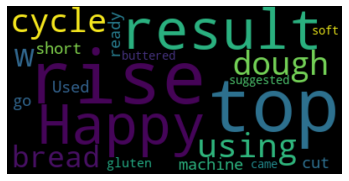

In [70]:
# Start with one review:
text = raw_interactions.review[4142]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

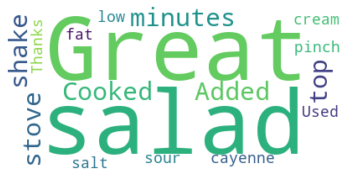

In [62]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [160]:
text = " ".join(str(review) for review in raw_recipes.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 45550662 words in the combination of all review.


In [161]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["made", "make", "added", "used", "thing", "makes", "use", "ingredient", "always",
                  "thank", "think", "thanks", "making", "really", "using", "lot", "little", "posted",
                  "use", "recipe", 'great', "good", "came", "way", "come", "served", "know", "even",
                 "will", "next", "one", "time", "taste", "tried", "well", "want", "work", "yet", "cookbook",
                 "much", "add", "delicious", "dish", "flavor", "recipes", "tried", "day", "cooking", "need",
                  "another", "include", "take", "find", "prep", "cut", "may", "keep", "usually", "sure", "better",
                  "wonderful", "eat", "comes", "nice", "best", "years ago", "adapted", "perfect",
                  "without", "amount", "thought", "give", "tasty", "ingredients",
                 "loved", "love", "try", "enjoy", "found", "got", "serve", "cook"])

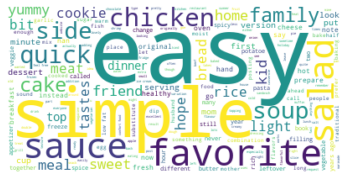

In [162]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [163]:
text = " ".join(str(review) for review in raw_recipes.tags)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 59405459 words in the combination of all review.


In [166]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["made", "make", "added", "used", "thing", "makes", "use", "ingredient", "always",
                  "thank", "think", "thanks", "making", "really", "using", "lot", "little", "posted",
                  "use", "recipe", 'great', "good", "came", "way", "come", "served", "know", "even",
                 "will", "next", "one", "time", "taste", "tried", "well", "want", "work", "yet", "cookbook",
                 "much", "add", "delicious", "dish", "flavor", "recipes", "tried", "day", "cooking", "need",
                  "another", "include", "take", "find", "prep", "cut", "may", "keep", "usually", "sure", "better",
                  "wonderful", "eat", "comes", "nice", "best", "years ago", "adapted", "perfect",
                  "without", "amount", "thought", "give", "tasty", "ingredients", "ingredient", "main", "make'",
                 "loved", "love", "try", "enjoy", "found", "got", "serve", "cook"])

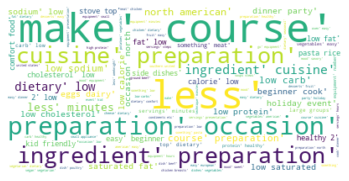

In [167]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()